In [ ]:
import pandas as pd
import pickle
import pandas_ta as ta
import talib as tb
import numpy as np
import matplotlib.pyplot as plt


from sklearn.calibration import LabelEncoder

from h4_helper_functions import read_price_data




from tqdm import tqdm

from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Sequential
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
price_data = pd.read_csv("training/USDJPY_H4_201001040000_202112310000.csv", delimiter='\t')
price_data['datetime'] = pd.to_datetime(price_data['<DATE>'] + ' ' + price_data['<TIME>'])
price_data.columns = price_data.columns.str.replace('<', '').str.replace('>', '').str.lower()
price_data['date'] = pd.to_datetime(price_data['date'])
price_data.sort_values(by='date', inplace=True)

In [ ]:
price_data.head()

,date,time,open,high,low,close,tickvol,vol,spread,datetime
0,2010-01-04,00:00:00,92.918,93.060,92.690,92.862,7065,0,20,2010-01-04 00:00:00
1,2010-01-04,04:00:00,92.861,93.050,92.712,93.039,5700,0,10,2010-01-04 04:00:00
2,2010-01-04,08:00:00,93.045,93.206,92.717,92.931,8860,0,15,2010-01-04 08:00:00
3,2010-01-04,12:00:00,92.930,92.937,92.477,92.629,7897,0,14,2010-01-04 12:00:00
4,2010-01-04,16:00:00,92.622,92.692,92.181,92.603,8018,0,17,2010-01-04 16:00:00


In [ ]:
"""Creating features"""
# Calculate log returns
price_data['log_return'] = np.log(price_data['close'] / price_data['close'].shift(1))

"""Using log return to get trend"""
import numpy as np
# Calculate daily log returns
price_data['log_return'] = np.log(price_data['close'] / price_data['close'].shift(1))

# Use the next candle's log return to define the trend
price_data['next_candle_log_return'] = price_data['log_return'].shift(-1)

# Define trend based on the next candle's log return
price_data['trend'] = price_data['next_candle_log_return'].apply(lambda x: 1 if x > 0 else -1)

# Drop rows with NaN values due to shifting
price_data.dropna(subset=['next_candle_log_return',], inplace=True)

# Drop intermediate columns if no longer needed
price_data.drop(columns=['next_candle_log_return'], inplace=True)

price_data.dropna(inplace=True)



"""Adding features"""
# Calculate 5-day moving average
price_data['ma_5'] = price_data['close'].rolling(window=5).mean()
# Calculate 10-day moving average
price_data['ma_10'] = price_data['close'].rolling(window=10).mean()
# Calculate 20-day moving average
price_data['ma_20'] = price_data['close'].rolling(window=20).mean()
# Calculate 50-day moving average
price_data['ma_50'] = price_data['close'].rolling(window=50).mean()
# Calculate 100-day moving average
price_data['ma_100'] = price_data['close'].rolling(window=100).mean()
# Calculate 200-day moving average
price_data['ma_200'] = price_data['close'].rolling(window=200).mean()

#Ema
price_data['ema_6']    = ta.ema(price_data['close'], length=6) #24 hours
price_data['ema_18']   = ta.ema(price_data['close'], length=18) #72 hours
price_data['ema_42']   = ta.ema(price_data['close'], length=42) #1 week
price_data['sma_50']   = ta.sma(price_data['close'], length=50) #3 and a half days
price_data['hull_21']  = ta.hma(price_data['close'], length=21)
price_data['ema6_18_x'] = (price_data['ema_6'] > price_data['ema_18']).astype(int)   # cross feature
price_data['slope_42'] = price_data['ema_42'].pct_change(1)

# Calculate ADX with a 10-day period
adx_price_data = ta.adx(
    high=price_data['high'],  # High prices
    low=price_data['low'],    # Low prices
    close=price_data['close'],  # Closing prices
    length=10  # Period for ADX calculation
)
adx_price_data.head(20)
price_data['adx_10'] = adx_price_data['ADX_10']  # Adjust to the actual column name

# Calculate MACD using pandas_ta
macd_price_data = ta.macd(
    close=price_data['close'],  # Closing prices
    fast=12,  # Fast EMA period
    slow=26,  # Slow EMA period
    signal=9  # Signal line period
)
# Add MACD components as features to the DataFrame
price_data['macd'] = macd_price_data['MACD_12_26_9']
price_data['macd_signal'] = macd_price_data['MACDs_12_26_9']
price_data['macd_hist'] = macd_price_data['MACDh_12_26_9']


# Calculate the PSAR
psar_price_data = ta.psar(
    high=price_data['high'],  # High prices
    low=price_data['low'],    # Low prices
    close=price_data['close'],  # Closing prices
    step=0.02,  # Acceleration factor
    max_step=0.2  # Maximum acceleration factor
)
psar_price_data.head()
# Add the trend direction column as a feature
price_data['psar_trend'] = psar_price_data['PSARr_0.02_0.2']

# Calculate the RSI
price_data['rsi'] = ta.rsi(
    close=price_data['close'],  # Closing prices
    length=14  # RSI period (default is 14)
)

# Calculate the Stochastic Oscillator
stoch_price_data = ta.stoch(
    high=price_data['high'],  # High prices
    low=price_data['low'],    # Low prices
    close=price_data['close'],  # Closing prices
    k=14,  # %K period (default is 14)
    d=3,   # %D smoothing period (default is 3)
)
# Add the %K and %D lines to the DataFrame
price_data['stoch_%k'] = stoch_price_data['STOCHk_14_3_3']
price_data['stoch_%d'] = stoch_price_data['STOCHd_14_3_3']

# Calculate the Williams %R
# Define the lookback period
lookback_period = 14
# Calculate the Highest High and Lowest Low for the lookback period
price_data['highest_high'] = price_data['high'].rolling(window=lookback_period).max()
price_data['lowest_low'] = price_data['low'].rolling(window=lookback_period).min()
# Calculate Williams %R
price_data['williams_%r'] = (
    (price_data['highest_high'] - price_data['close']) / 
    (price_data['highest_high'] - price_data['lowest_low'])
) * -100
# Drop the intermediate columns if not needed
price_data.drop(columns=['highest_high', 'lowest_low'], inplace=True)

# Calculate the ATR
price_data['atr'] = ta.atr(
    high=price_data['high'],  # High prices
    low=price_data['low'],    # Low prices
    close=price_data['close'],  # Closing prices
    length=14  # Lookback period (default is 14)
)

# Calculate Bollinger Bands
bbands = ta.bbands(
    close=price_data['close'],  # Closing prices
    length=20,  # Lookback period for the SMA (default is 20)
    std=2  # Number of standard deviations (default is 2)
)
# Add Bollinger Band components to the DataFrame
price_data['bb_upper'] = bbands['BBU_20_2.0']  # Upper Band
price_data['bb_middle'] = bbands['BBM_20_2.0']  # Middle Band
price_data['bb_lower'] = bbands['BBL_20_2.0']  # Lower Band

# Calculate the rolling standard deviation
# Define the rolling window period
sd_window_period = 20
price_data['std_dev'] = price_data['close'].rolling(window=sd_window_period).std()

In [ ]:
price_data.head()

,date,time,open,high,low,close,tickvol,vol,spread,datetime,...,psar_trend,rsi,stoch_%k,stoch_%d,williams_%r,atr,bb_upper,bb_middle,bb_lower,std_dev
1,2010-01-04,04:00:00,92.861,93.050,92.712,93.039,5700,0,10,2010-01-04 04:00:00,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,08:00:00,93.045,93.206,92.717,92.931,8860,0,15,2010-01-04 08:00:00,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-04,12:00:00,92.930,92.937,92.477,92.629,7897,0,14,2010-01-04 12:00:00,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-04,16:00:00,92.622,92.692,92.181,92.603,8018,0,17,2010-01-04 16:00:00,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-01-04,20:00:00,92.602,92.613,92.372,92.409,4466,0,18,2010-01-04 20:00:00,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
opn = price_data['open'].values
hi  = price_data['high'].values
lo  = price_data['low'].values
cl  = price_data['close'].values

In [ ]:
price_data['hammer']         = tb.CDLHAMMER(opn, hi, lo, cl)

In [ ]:
price_data.head()

,date,time,open,high,low,close,tickvol,vol,spread,datetime,...,rsi,stoch_%k,stoch_%d,williams_%r,atr,bb_upper,bb_middle,bb_lower,std_dev,hammer
1,2010-01-04,04:00:00,92.861,93.050,92.712,93.039,5700,0,10,2010-01-04 04:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2010-01-04,08:00:00,93.045,93.206,92.717,92.931,8860,0,15,2010-01-04 08:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2010-01-04,12:00:00,92.930,92.937,92.477,92.629,7897,0,14,2010-01-04 12:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2010-01-04,16:00:00,92.622,92.692,92.181,92.603,8018,0,17,2010-01-04 16:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,2010-01-04,20:00:00,92.602,92.613,92.372,92.409,4466,0,18,2010-01-04 20:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
price_data['inv_hammer']     = tb.CDLINVERTEDHAMMER(opn, hi, lo, cl)

# 2) Engulfing patterns
price_data['engulfing']      = tb.CDLENGULFING(opn, hi, lo, cl)

# 3) Morning / Evening Star
price_data['morning_star']   = tb.CDLMORNINGSTAR(opn, hi, lo, cl, penetration=0)
price_data['evening_star']   = tb.CDLEVENINGSTAR(opn, hi, lo, cl, penetration=0)

# 4) Doji
price_data['doji']           = tb.CDLDOJI(opn, hi, lo, cl)

# 5) Three‐Line Strike
price_data['three_strike']   = tb.CDL3LINESTRIKE(opn, hi, lo, cl)

price_data['Target'] = (price_data['log_return'].shift(-1) > 0).astype(int)  # 1 if the next candle's log return is positive, 0 otherwise

In [ ]:
price_data = price_data.set_index('datetime').sort_index()

In [ ]:
for col in ['hammer','inv_hammer','engulfing','morning_star',
            'evening_star','doji','three_strike']:
    price_data[f'{col}_flag'] = (price_data[col] > 0).astype(int)
    # if you also want to capture bearish, you could do:
    # price_data[f'{col}_bear'] = (price_data[col] < 0).astype(int)

# Clean-up: if you only want the flags, drop the raw pattern scores
price_data.drop(columns=[
    'hammer','inv_hammer','engulfing','morning_star',
    'evening_star','doji','three_strike'
], inplace=True)

In [ ]:
# 2) Load & prepare each auxiliary pair
def load_h4_close(path, prefix):
    # parse the two fields into one "datetime"
    df = pd.read_csv(
        path, 
        sep='\t',
        parse_dates={'datetime': ['<DATE>', '<TIME>']}, 
        infer_datetime_format=True
    )
    # normalize the column names
    df.columns = df.columns.str.replace('<','', regex=False) \
                           .str.replace('>','', regex=False) \
                           .str.lower()
    # set that rich datetime index
    df = df.set_index('datetime').sort_index()
    # keep only the one renamed close column
    return df[['close']].rename(columns={'close': f'{prefix}_close'})

In [ ]:
audjpy = load_h4_close('training/AUDJPY_H4_201001040000_202112310000.csv', 'audjpy')
audusd = load_h4_close('training/AUDUSD_H4_201001040000_202112310000.csv', 'audusd')
chfjpy = load_h4_close('training/CHFJPY_H4_201001040000_202112310000.csv', 'chfjpy')
eurjpy = load_h4_close('training/EURJPY_H4_201001040000_202112310000.csv', 'eurjpy')
eurusd = load_h4_close('training/EURUSD_H4_201001040000_202112310000.csv', 'eurusd')
gbpjpy = load_h4_close('training/GBPJPY_H4_201001040000_202112310000.csv', 'gbpjpy')
gbpusd = load_h4_close('training/GBPUSD_H4_201001040000_202112310000.csv', 'gbpusd')
nzdusd = load_h4_close('training/NZDUSD_H4_201001040000_202112310000.csv', 'nzdusd')
usdcad = load_h4_close('training/USDCAD_H4_201001040000_202112310000.csv', 'usdcad')
usdchf = load_h4_close('training/USDCHF_H4_201001040000_202112310000.csv', 'usdchf')
xauusd = load_h4_close('training/XAUUSD_H4_201001040000_202112310000.csv', 'xauusd')

aux = pd.concat([
    audjpy, audusd, chfjpy, eurjpy,
    eurusd, gbpjpy, gbpusd, nzdusd,
    usdcad, usdchf, xauusd
], axis=1)

# one join, by index
price_data = price_data.join(aux, how='left')

<ipython-input-12-36aba6d37d5b>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-date

In [ ]:
price_data.columns

Index(['date', 'time', 'open', 'high', 'low', 'close', 'tickvol', 'vol',
       'spread', 'log_return', 'trend', 'ma_5', 'ma_10', 'ma_20', 'ma_50',
       'ma_100', 'ma_200', 'ema_6', 'ema_18', 'ema_42', 'sma_50', 'hull_21',
       'ema6_18_x', 'slope_42', 'adx_10', 'macd', 'macd_signal', 'macd_hist',
       'psar_trend', 'rsi', 'stoch_%k', 'stoch_%d', 'williams_%r', 'atr',
       'bb_upper', 'bb_middle', 'bb_lower', 'std_dev', 'Target', 'hammer_flag',
       'inv_hammer_flag', 'engulfing_flag', 'morning_star_flag',
       'evening_star_flag', 'doji_flag', 'three_strike_flag', 'audjpy_close',
       'audusd_close', 'chfjpy_close', 'eurjpy_close', 'eurusd_close',
       'gbpjpy_close', 'gbpusd_close', 'nzdusd_close', 'usdcad_close',
       'usdchf_close', 'xauusd_close'],
      dtype='object')

In [ ]:
price_data.drop(columns=['vol'], inplace=True)

In [ ]:
price_data.head()

,date,time,open,high,low,close,tickvol,spread,log_return,trend,...,audusd_close,chfjpy_close,eurjpy_close,eurusd_close,gbpjpy_close,gbpusd_close,nzdusd_close,usdcad_close,usdchf_close,xauusd_close
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-04 04:00:00,2010-01-04,04:00:00,92.861,93.050,92.712,93.039,5700,10,0.001904,-1,...,0.89822,89.693,132.999,1.42949,149.656,1.60850,0.72174,1.04683,1.03698,1102.85
2010-01-04 08:00:00,2010-01-04,08:00:00,93.045,93.206,92.717,92.931,8860,15,-0.001161,-1,...,0.90439,89.769,133.618,1.43778,150.318,1.61744,0.72747,1.03988,1.03493,1113.10
2010-01-04 12:00:00,2010-01-04,12:00:00,92.930,92.937,92.477,92.629,7897,14,-0.003255,-1,...,0.90824,89.947,133.651,1.44266,149.764,1.61656,0.72998,1.03953,1.02969,1121.05
2010-01-04 16:00:00,2010-01-04,16:00:00,92.622,92.692,92.181,92.603,8018,17,-0.000281,-1,...,0.91239,89.914,133.466,1.44120,149.053,1.60958,0.73418,1.04072,1.02942,1116.40
2010-01-04 20:00:00,2010-01-04,20:00:00,92.602,92.613,92.372,92.409,4466,18,-0.002097,-1,...,0.91188,89.684,133.174,1.44111,148.665,1.60877,0.73400,1.04165,1.02993,1121.05


In [ ]:
price_data.dropna(inplace=True)

In [ ]:
price_data.head()

,date,time,open,high,low,close,tickvol,spread,log_return,trend,...,audusd_close,chfjpy_close,eurjpy_close,eurusd_close,gbpjpy_close,gbpusd_close,nzdusd_close,usdcad_close,usdchf_close,xauusd_close
datetime,,,,,,,,,,,,,,,,,,,,,
2010-02-18 00:00:00,2010-02-18,00:00:00,91.168,91.198,90.881,90.949,6938,17,0.001188,1,...,0.89520,84.130,123.359,1.35634,142.327,1.56482,0.69997,1.04864,1.08050,1103.70
2010-02-18 04:00:00,2010-02-18,04:00:00,90.951,91.000,90.829,90.959,5419,10,0.000110,1,...,0.89800,84.321,123.633,1.35918,142.522,1.56693,0.70206,1.04617,1.07843,1103.56
2010-02-18 08:00:00,2010-02-18,08:00:00,90.957,91.048,90.727,90.841,9229,10,-0.012765,1,...,0.89671,84.165,123.376,1.35815,141.776,1.56079,0.70021,1.04567,1.07903,1106.28
2010-02-18 20:00:00,2010-02-18,20:00:00,91.193,92.041,91.187,92.008,8285,17,0.008766,-1,...,0.89217,84.655,124.140,1.34923,142.417,1.54818,0.69599,1.05040,1.08624,1108.55
2010-02-19 00:00:00,2010-02-19,00:00:00,92.006,92.078,91.718,91.781,8607,17,0.008996,1,...,0.89110,84.404,123.766,1.34846,141.653,1.54361,0.69611,1.04896,1.08683,1104.63


In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
y = le.fit_transform(price_data['trend'])   # 0 = down, 1 = up

In [ ]:
X_num = (
    price_data
    .drop(columns=['trend', 'Target'], errors='ignore')    # remove label cols
    .select_dtypes(include=[np.number])                    # keep only floats/ints
    .fillna(0)                                             # or another imputation
)

In [ ]:
mi = mutual_info_classif(X_num, y, random_state=42)

In [ ]:
mi_series = pd.Series(mi, index=X_num.columns).sort_values(ascending=False)

In [ ]:
print("Feature ranking by mutual information:")
for i, (feat, score) in enumerate(mi_series.items(), start=1):
    print(f"{i:2d}. {feat:20s} → MI = {score:.4f}")

Feature ranking by mutual information:
 1. williams_%r          → MI = 0.0143
 2. close                → MI = 0.0109
 3. gbpusd_close         → MI = 0.0097
 4. ema_6                → MI = 0.0096
 5. stoch_%k             → MI = 0.0084
 6. morning_star_flag    → MI = 0.0081
 7. low                  → MI = 0.0077
 8. log_return           → MI = 0.0077
 9. nzdusd_close         → MI = 0.0073
10. slope_42             → MI = 0.0062
11. macd_signal          → MI = 0.0060
12. macd_hist            → MI = 0.0047
13. ma_10                → MI = 0.0042
14. eurusd_close         → MI = 0.0035
15. hull_21              → MI = 0.0035
16. adx_10               → MI = 0.0034
17. stoch_%d             → MI = 0.0034
18. doji_flag            → MI = 0.0031
19. ema_18               → MI = 0.0018
20. ma_50                → MI = 0.0018
21. gbpjpy_close         → MI = 0.0018
22. sma_50               → MI = 0.0017
23. rsi                  → MI = 0.0015
24. hammer_flag          → MI = 0.0009
25. audjpy_close         

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 1) Prepare X and y exactly as you did for MI
le = LabelEncoder()
y = le.fit_transform(price_data['trend'])   # 0 = down, 1 = up

In [ ]:
X = (
    price_data
    .drop(columns=['trend', 'Target'], errors='ignore')
    .select_dtypes(include=[np.number])
    .fillna(0)
)

In [ ]:
# 2) Train a Random Forest
rf = RandomForestClassifier(
    n_estimators=200,    # you can tune this
    max_depth=None,      # let trees grow fully
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
rf_ranking = importances.sort_values(ascending=False)

In [ ]:
# 4) Print the top 20
print("Feature ranking by Random Forest importance:")
for i, (feat, score) in enumerate(rf_ranking.iloc[:20].items(), start=1):
    print(f"{i:2d}. {feat:20s} → Importance = {score:.4f}")

Feature ranking by Random Forest importance:
 1. williams_%r          → Importance = 0.0453
 2. log_return           → Importance = 0.0409
 3. rsi                  → Importance = 0.0352
 4. stoch_%d             → Importance = 0.0349
 5. stoch_%k             → Importance = 0.0346
 6. tickvol              → Importance = 0.0333
 7. macd_hist            → Importance = 0.0322
 8. adx_10               → Importance = 0.0312
 9. slope_42             → Importance = 0.0308
10. std_dev              → Importance = 0.0300
11. macd                 → Importance = 0.0291
12. macd_signal          → Importance = 0.0285
13. atr                  → Importance = 0.0284
14. xauusd_close         → Importance = 0.0257
15. usdcad_close         → Importance = 0.0252
16. usdchf_close         → Importance = 0.0251
17. nzdusd_close         → Importance = 0.0250
18. audjpy_close         → Importance = 0.0246
19. gbpusd_close         → Importance = 0.0246
20. eurusd_close         → Importance = 0.0240


In [ ]:
importances

open                 0.016094
high                 0.015446
low                  0.015300
close                0.015600
tickvol              0.033310
spread               0.010917
log_return           0.040921
ma_5                 0.014656
ma_10                0.014174
ma_20                0.013620
ma_50                0.015053
ma_100               0.017525
ma_200               0.019570
ema_6                0.013797
ema_18               0.013310
ema_42               0.014100
sma_50               0.015100
hull_21              0.014985
ema6_18_x            0.001432
slope_42             0.030777
adx_10               0.031188
macd                 0.029135
macd_signal          0.028537
macd_hist            0.032193
psar_trend           0.002688
rsi                  0.035236
stoch_%k             0.034627
stoch_%d             0.034872
williams_%r          0.045280
atr                  0.028369
bb_upper             0.015750
bb_middle            0.014068
bb_lower             0.016132
std_dev   

In [ ]:
print("Feature ranking by Random Forest importance:")
for i, (feat, score) in enumerate(rf_ranking.iloc[:52].items(), start=1):
    print(f"{i:2d}. {feat:20s} → Importance = {score:.4f}")

Feature ranking by Random Forest importance:
 1. williams_%r          → Importance = 0.0453
 2. log_return           → Importance = 0.0409
 3. rsi                  → Importance = 0.0352
 4. stoch_%d             → Importance = 0.0349
 5. stoch_%k             → Importance = 0.0346
 6. tickvol              → Importance = 0.0333
 7. macd_hist            → Importance = 0.0322
 8. adx_10               → Importance = 0.0312
 9. slope_42             → Importance = 0.0308
10. std_dev              → Importance = 0.0300
11. macd                 → Importance = 0.0291
12. macd_signal          → Importance = 0.0285
13. atr                  → Importance = 0.0284
14. xauusd_close         → Importance = 0.0257
15. usdcad_close         → Importance = 0.0252
16. usdchf_close         → Importance = 0.0251
17. nzdusd_close         → Importance = 0.0250
18. audjpy_close         → Importance = 0.0246
19. gbpusd_close         → Importance = 0.0246
20. eurusd_close         → Importance = 0.0240
21. audusd_clos

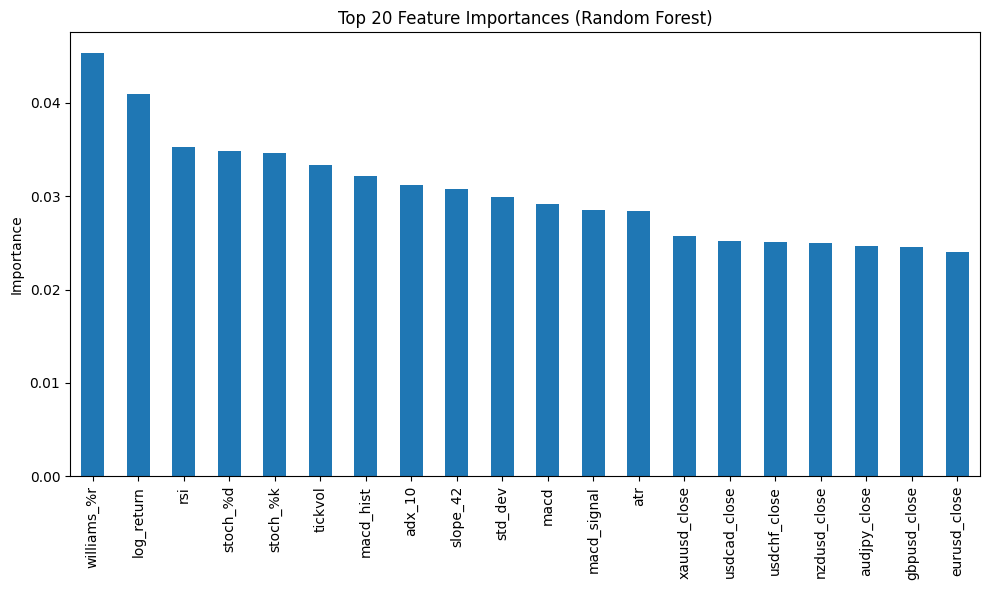

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
rf_ranking.iloc[:20].plot.bar()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# 2) Combine into one DataFrame
df_imp = pd.DataFrame({
    'MI' : mi_series,
    'RF' : rf_ranking
}).fillna(0)    # anything missing in one method becomes zero

In [ ]:
df_imp['MI_n'] = df_imp['MI'] / df_imp['MI'].abs().max()
df_imp['RF_n'] = df_imp['RF'] / df_imp['RF'].abs().max()

In [ ]:
df_imp['consensus'] = df_imp['MI_n'] + df_imp['RF_n']

In [ ]:
top_mi        = df_imp.sort_values('MI',        ascending=False).head(10)
top_rf        = df_imp.sort_values('RF',        ascending=False).head(10)
top_consensus = df_imp.sort_values('consensus', ascending=False).head(10)

In [ ]:
print("Top 10 by Mutual Information:\n", top_mi[['MI']])
print("\nTop 10 by Random Forest:\n",    top_rf[['RF']])
print("\nTop 10 by Consensus:\n",        top_consensus[['MI','RF','consensus']])

Top 10 by Mutual Information:
                          MI
williams_%r        0.014335
close              0.010898
gbpusd_close       0.009690
ema_6              0.009603
stoch_%k           0.008350
morning_star_flag  0.008114
low                0.007737
log_return         0.007675
nzdusd_close       0.007318
slope_42           0.006228

Top 10 by Random Forest:
                    RF
williams_%r  0.045280
log_return   0.040921
rsi          0.035236
stoch_%d     0.034872
stoch_%k     0.034627
tickvol      0.033310
macd_hist    0.032193
adx_10       0.031188
slope_42     0.030777
std_dev      0.029960

Top 10 by Consensus:
                     MI        RF  consensus
williams_%r   0.014335  0.045280   2.000000
log_return    0.007675  0.040921   1.439127
stoch_%k      0.008350  0.034627   1.347244
gbpusd_close  0.009690  0.024577   1.218761
slope_42      0.006228  0.030777   1.114181
close         0.010898  0.015600   1.104736
nzdusd_close  0.007318  0.025004   1.062722
macd_signal   0.0

In [ ]:
def build_best(input_dim):
    m = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.0),
        Dense(64, activation='relu'),
        Dropout(0.0),
        Dense(1,  activation='sigmoid')
    ])
    m.compile(
        optimizer=Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']      # <— keyword here
    )
    return m

In [ ]:
model_cons = build_best(len(consensus_feats))

# 7) Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping('val_loss', patience=10, restore_best_weights=True)

history_cons = model_cons.fit(
    Xc_train, yc_train,
    validation_data=(Xc_test, yc_test),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5362 - loss: 0.6895 - val_accuracy: 0.5548 - val_loss: 0.6823
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.5680 - loss: 0.6818 - val_accuracy: 0.5551 - val_loss: 0.6808
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.6790 - val_accuracy: 0.5609 - val_loss: 0.6890
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5719 - loss: 0.6792 - val_accuracy: 0.5663 - val_loss: 0.6811
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5752 - loss: 0.6791 - val_accuracy: 0.5666 - val_loss: 0.6811
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.5781 - loss: 0.6768 - val_accuracy: 0.5622 - val_loss: 0.6797
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5781 - loss: 0.6765 - val_accuracy: 0.5650 - val_loss: 0.6802
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.5842 - loss: 0.6764 - 

In [ ]:
# 8) Evaluate out of sample
loss_c, acc_c = model_cons.evaluate(Xc_test, yc_test, verbose=0)
print(f"Consensus‐feature model →  Acc: {acc_c:.4f}, Loss: {loss_c:.4f}")

Consensus‐feature model →  Acc: 0.5669, Loss: 0.6790


In [ ]:
top_mi        = df_imp.sort_values('MI',        ascending=False).head(20)
top_rf        = df_imp.sort_values('RF',        ascending=False).head(20)
top_consensus = df_imp.sort_values('consensus', ascending=False).head(20)

In [ ]:
print("Top 10 by Mutual Information:\n", top_mi[['MI']])
print("\nTop 10 by Random Forest:\n",    top_rf[['RF']])
print("\nTop 10 by Consensus:\n",        top_consensus[['MI','RF','consensus']])

Top 10 by Mutual Information:
                          MI
williams_%r        0.014335
close              0.010898
gbpusd_close       0.009690
ema_6              0.009603
stoch_%k           0.008350
morning_star_flag  0.008114
low                0.007737
log_return         0.007675
nzdusd_close       0.007318
slope_42           0.006228
macd_signal        0.005967
macd_hist          0.004742
ma_10              0.004193
eurusd_close       0.003511
hull_21            0.003478
adx_10             0.003373
stoch_%d           0.003358
doji_flag          0.003082
ema_18             0.001819
ma_50              0.001789

Top 10 by Random Forest:
                     RF
williams_%r   0.045280
log_return    0.040921
rsi           0.035236
stoch_%d      0.034872
stoch_%k      0.034627
tickvol       0.033310
macd_hist     0.032193
adx_10        0.031188
slope_42      0.030777
std_dev       0.029960
macd          0.029135
macd_signal   0.028537
atr           0.028369
xauusd_close  0.025687
usdcad_cl

In [ ]:
def build_best(input_dim):
    m = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1,  activation='sigmoid')
    ])
    m.compile(
        optimizer=Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']      # <— keyword here
    )
    return m

In [ ]:
model_cons = build_best(len(consensus_feats))

In [ ]:
# 7) Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping('val_loss', patience=10, restore_best_weights=True)

history_cons = model_cons.fit(
    Xc_train, yc_train,
    validation_data=(Xc_test, yc_test),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# 8) Evaluate out of sample
loss_c, acc_c = model_cons.evaluate(Xc_test, yc_test, verbose=0)
print(f"Consensus‐feature model →  Acc: {acc_c:.4f}, Loss: {loss_c:.4f}")

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5201 - loss: 0.6925 - val_accuracy: 0.5546 - val_loss: 0.6835
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.5617 - loss: 0.6835 - val_accuracy: 0.5609 - val_loss: 0.6825
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6825 - val_accuracy: 0.5617 - val_loss: 0.6826
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.5628 - loss: 0.6831 - val_accuracy: 0.5614 - val_loss: 0.6808
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5645 - loss: 0.6816 - val_accuracy: 0.5652 - val_loss: 0.6813
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.5758 - loss: 0.6786 - val_accuracy: 0.5628 - val_loss: 0.6799
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5661 - loss: 0.6809 - val_accuracy: 0.5625 - val_loss: 0.6824
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5755 - loss: 0.6813 - 

In [ ]:
def build_best(input_dim, l2_strength=1e-4):
    m = Sequential([
        Dense(
            128, activation='relu',
            input_shape=(input_dim,),
            kernel_regularizer=l2(l2_strength)
        ),
        Dropout(0.3),
        Dense(
            128, activation='relu',
            kernel_regularizer=l2(l2_strength)
        ),
        Dropout(0.3),
        Dense(
            1, activation='sigmoid',
            kernel_regularizer=l2(l2_strength)
        )
    ])
    m.compile(
        optimizer=Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return m

In [ ]:
model_cons = build_best(len(consensus_feats))

In [ ]:
# 7) Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping('val_loss', patience=10, restore_best_weights=True)

history_cons = model_cons.fit(
    Xc_train, yc_train,
    validation_data=(Xc_test, yc_test),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# 8) Evaluate out of sample
loss_c, acc_c = model_cons.evaluate(Xc_test, yc_test, verbose=0)
print(f"Consensus‐feature model →  Acc: {acc_c:.4f}, Loss: {loss_c:.4f}")

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5252 - loss: 0.7059 - val_accuracy: 0.5559 - val_loss: 0.6918
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5533 - loss: 0.6930 - val_accuracy: 0.5567 - val_loss: 0.6902
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5615 - loss: 0.6897 - val_accuracy: 0.5658 - val_loss: 0.6896
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5613 - loss: 0.6902 - val_accuracy: 0.5609 - val_loss: 0.6861
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.5790 - loss: 0.6841 - val_accuracy: 0.5589 - val_loss: 0.6854
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5720 - loss: 0.6861 - val_accuracy: 0.5633 - val_loss: 0.6848
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.5688 - loss: 0.6857 - val_accuracy: 0.5658 - val_loss: 0.6859
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5754 - loss: 0.6838 - 

In [ ]:
print("\nTop 10 by Consensus:\n",        top_consensus[['MI','RF','consensus']])


Top 10 by Consensus:
                     MI        RF  consensus
williams_%r   0.014335  0.045280   2.000000
log_return    0.007675  0.040921   1.439127
stoch_%k      0.008350  0.034627   1.347244
gbpusd_close  0.009690  0.024577   1.218761
slope_42      0.006228  0.030777   1.114181
close         0.010898  0.015600   1.104736
nzdusd_close  0.007318  0.025004   1.062722
macd_signal   0.005967  0.028537   1.046507
macd_hist     0.004742  0.032193   1.041748
stoch_%d      0.003358  0.034872   1.004385
ema_6         0.009603  0.013797   0.974583
adx_10        0.003373  0.031188   0.924120
rsi           0.001499  0.035236   0.882771
low           0.007737  0.015300   0.877611
eurusd_close  0.003511  0.023983   0.774596
tickvol       0.000445  0.033310   0.766703
std_dev       0.000000  0.029960   0.661657
macd          0.000000  0.029135   0.643446
gbpjpy_close  0.001779  0.022948   0.630909
atr           0.000000  0.028369   0.626531


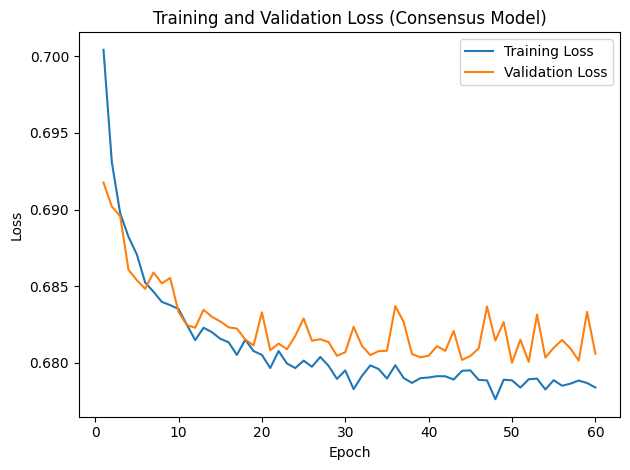

In [ ]:
# 1) Extract loss values
train_loss = history_cons.history['loss']
val_loss   = history_cons.history['val_loss']
epochs     = range(1, len(train_loss) + 1)

# 2) Plot
plt.figure()
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss (Consensus Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.tight_layout()
plt.show()

In [ ]:
new_price_data = pd.read_csv("testing/USDJPY_H4_202201030000_202505270800.csv", delimiter='\t')
new_price_data['datetime'] = pd.to_datetime(new_price_data['<DATE>'] + ' ' + new_price_data['<TIME>'])
new_price_data.columns = new_price_data.columns.str.replace('<', '').str.replace('>', '').str.lower()
new_price_data['date'] = pd.to_datetime(new_price_data['date'])
new_price_data.set_index('datetime', inplace=True)
new_price_data.sort_values(by='date', inplace=True)

new_price_data.head()
new_price_data.tail()


# 3) Compute the same features on this new_price_data
# 3a) log returns & target
new_price_data['log_return'] = np.log(new_price_data['close']/new_price_data['close'].shift(1))
new_price_data['Target']     = (new_price_data['log_return'].shift(-1) > 0).astype(int)

# 3b) Williams %R
hh = new_price_data['high'].rolling(14).max()
ll = new_price_data['low'].rolling(14).min()
new_price_data['williams_%r'] = ( (hh - new_price_data['close'])/(hh-ll) ) * -100

# 3c) Stochastic
stoch = ta.stoch(new_price_data['high'], new_price_data['low'], new_price_data['close'], k=14, d=3)
new_price_data['stoch_%k'] = stoch['STOCHk_14_3_3']
new_price_data['stoch_%d'] = stoch['STOCHd_14_3_3']

# 3d) RSI
new_price_data['rsi'] = ta.rsi(new_price_data['close'], length=14)

# 3e) MACD
macd = ta.macd(new_price_data['close'], fast=12, slow=26, signal=9)
new_price_data['macd']        = macd['MACD_12_26_9']
new_price_data['macd_signal'] = macd['MACDs_12_26_9']
new_price_data['macd_hist']   = macd['MACDh_12_26_9']

# 3f) ADX
adx = ta.adx(new_price_data['high'], new_price_data['low'], new_price_data['close'], length=10)
new_price_data['adx_10'] = adx['ADX_10']

# 3g) Slope of EMA42
ema42 = ta.ema(new_price_data['close'], length=42)
new_price_data['slope_42'] = ema42.pct_change(1)

# 3h) ATR
new_price_data['atr'] = ta.atr(new_price_data['high'], new_price_data['low'], new_price_data['close'], length=14)

# 3i) Tick volume stays as-is (tickvol)
# 3j) Std dev
new_price_data['std_dev'] = new_price_data['close'].rolling(20).std()

# 4) Load the other pairs and join their CLOSEs

audjpy = load_h4_close('testing/AUDJPY_H4_202201030000_202506250000.csv', 'audjpy')
audusd = load_h4_close('testing/AUDUSD_H4_202201030000_202506250000.csv', 'audusd')
gbpusd = load_h4_close('testing/GBPUSD_H4_202201030000_202506250000.csv', 'gbpusd')
nzdusd = load_h4_close('testing/NZDUSD_H4_202201030000_202506250000.csv', 'nzdusd')
usdcad = load_h4_close('testing/USDCAD_H4_202201030000_202506250000.csv', 'usdcad')
usdchf = load_h4_close('testing/USDCHF_H4_202201030000_202506250000.csv', 'usdchf')
xauusd = load_h4_close('testing/XAUUSD_H4_202201030000_202506250000.csv', 'xauusd')

aux = pd.concat([
    audjpy, audusd, gbpusd, nzdusd,
    usdcad, usdchf, xauusd
], axis=1)

# one join, by index
new_price_data = new_price_data.join(aux, how='left')

new_price_data.head()

new_price_data.dropna(inplace=True)

<ipython-input-12-36aba6d37d5b>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-date

In [ ]:
# 1) Define your consensus features (must match training)
consensus_feats = [
    'williams_%r',
    'log_return',
    'stoch_%k',
    'gbpusd_close',
    'slope_42',
    'close',
    'nzdusd_close',
    'macd_signal',
    'macd_hist',
    'stoch_%d'
]

In [ ]:
# 2) Build X_new and y_new
X_new = new_price_data[consensus_feats].copy()
y_new = new_price_data['Target'].values    # 1 = up, 0 = down

In [ ]:
# 3) Drop any rows with NaNs in X_new or in the target
mask = ~X_new.isna().any(axis=1)
X_new = X_new[mask]
y_new = y_new[mask]

In [ ]:
# 1) Define your consensus features (must match training)
consensus_feats = [
    'williams_%r',
    'log_return',
    'stoch_%k',
    'gbpusd_close',
    'slope_42',
    'close',
    'nzdusd_close',
    'macd_signal',
    'macd_hist',
    'stoch_%d', 
    'ema_6', 
    'adx_10', 
    'rsi',
    'low',
    'eurusd_close',
    'tickvol',
    'std_dev',
    'macd',
    'gbpjpy_close',
    'atr'
]

In [ ]:
"""Testing on new data"""
new_price_data = pd.read_csv("testing/USDJPY_H4_202201030000_202505270800.csv", delimiter='\t')
new_price_data['datetime'] = pd.to_datetime(new_price_data['<DATE>'] + ' ' + new_price_data['<TIME>'])
new_price_data.columns = new_price_data.columns.str.replace('<', '').str.replace('>', '').str.lower()
new_price_data['date'] = pd.to_datetime(new_price_data['date'])
new_price_data.set_index('datetime', inplace=True)
new_price_data.sort_values(by='date', inplace=True)

new_price_data.head()
new_price_data.tail()


# 3) Compute the same features on this new_price_data
# 3a) log returns & target
new_price_data['log_return'] = np.log(new_price_data['close']/new_price_data['close'].shift(1))
new_price_data['Target']     = (new_price_data['log_return'].shift(-1) > 0).astype(int)

# 3b) Williams %R
hh = new_price_data['high'].rolling(14).max()
ll = new_price_data['low'].rolling(14).min()
new_price_data['williams_%r'] = ( (hh - new_price_data['close'])/(hh-ll) ) * -100

# 3c) Stochastic
stoch = ta.stoch(new_price_data['high'], new_price_data['low'], new_price_data['close'], k=14, d=3)
new_price_data['stoch_%k'] = stoch['STOCHk_14_3_3']
new_price_data['stoch_%d'] = stoch['STOCHd_14_3_3']

# 3d) RSI
new_price_data['rsi'] = ta.rsi(new_price_data['close'], length=14)

# 3e) MACD
macd = ta.macd(new_price_data['close'], fast=12, slow=26, signal=9)
new_price_data['macd']        = macd['MACD_12_26_9']
new_price_data['macd_signal'] = macd['MACDs_12_26_9']
new_price_data['macd_hist']   = macd['MACDh_12_26_9']

# 3f) ADX
adx = ta.adx(new_price_data['high'], new_price_data['low'], new_price_data['close'], length=10)
new_price_data['adx_10'] = adx['ADX_10']

# 3g) Slope of EMA42
ema42 = ta.ema(new_price_data['close'], length=42)
new_price_data['slope_42'] = ema42.pct_change(1)

# 3h) ATR
new_price_data['atr'] = ta.atr(new_price_data['high'], new_price_data['low'], new_price_data['close'], length=14)

# 3i) Tick volume stays as-is (tickvol)
# 3j) Std dev
new_price_data['std_dev'] = new_price_data['close'].rolling(20).std()

new_price_data['ema_6'] = ta.ema(new_price_data['close'], length=6)


# 4) Load the other pairs and join their CLOSEs

gbpusd = load_h4_close('testing/GBPUSD_H4_202201030000_202506250000.csv', 'gbpusd')
nzdusd = load_h4_close('testing/NZDUSD_H4_202201030000_202506250000.csv', 'nzdusd')
eurusd = load_h4_close('testing/EURUSD_H4_202201030000_202506250000.csv', 'eurusd')
gbpjpy = load_h4_close('testing/GBPJPY_H4_202201030000_202506250000.csv', 'gbpjpy')


aux = pd.concat([
    audjpy, audusd, gbpusd, nzdusd,
    usdcad, usdchf, xauusd, eurusd, gbpjpy
], axis=1)

# one join, by index
new_price_data = new_price_data.join(aux, how='left')

new_price_data.head()

new_price_data.dropna(inplace=True)




# 1) Define your consensus features (must match training)
consensus_feats = [
    'williams_%r',
    'log_return',
    'stoch_%k',
    'gbpusd_close',
    'slope_42',
    'close',
    'nzdusd_close',
    'macd_signal',
    'macd_hist',
    'stoch_%d', 
    'ema_6', 
    'adx_10', 
    'rsi',
    'low',
    'eurusd_close',
    'tickvol',
    'std_dev',
    'macd',
    'gbpjpy_close',
    'atr'
]

<ipython-input-12-36aba6d37d5b>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-12-36aba6d37d5b>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-date

In [ ]:
# 2) Build X_new and y_new
X_new = new_price_data[consensus_feats].copy()
y_new = new_price_data['Target'].values    # 1 = up, 0 = down

In [ ]:
# 3) Drop any rows with NaNs in X_new or in the target
mask = ~X_new.isna().any(axis=1)
X_new = X_new[mask]
y_new = y_new[mask]

In [ ]:
X_new_scaled = scaler_cons.transform(X_new)

C:\Users\edmon\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
# 5) Evaluate loss & accuracy
loss_new, acc_new = model_cons.evaluate(X_new_scaled, y_new, verbose=0)
print(f"Consensus model on NEW data →  Acc: {acc_new:.4f}, Loss: {loss_new:.4f}")

Consensus model on NEW data →  Acc: 0.5860, Loss: 0.6773


In [ ]:
y_pred = (model_cons.predict(X_new_scaled) > 0.5).astype(int).ravel()
from sklearn.metrics import accuracy_score
print("Accuracy (sklearn):", accuracy_score(y_new, y_pred))

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
Accuracy (sklearn): 0.5860019175455418


In [ ]:
# 1) Make predictions (0/1) and map to “buy”/“sell”
y_pred_prob = model_cons.predict(X_new_scaled).ravel()
y_pred_lbl  = (y_pred_prob > 0.5).astype(int)
predictions = np.where(y_pred_lbl == 1, 'buy', 'sell')

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


In [ ]:
# 2) True labels as “buy”/“sell”
true_labels = np.where(y_new == 1, 'buy', 'sell')

# 3) Timestamps for each row (masked to match X_new_scaled & y_new)
timestamps = new_price_data.index[mask]

# 4) Assemble into a DataFrame
df_test_preds = pd.DataFrame({
    'timestamp' : timestamps,
    'prediction': predictions,
    'true_label': true_labels
})

In [ ]:
df_test_preds.head()

,timestamp,prediction,true_label
0,2022-01-12 20:00:00,buy,buy
1,2022-01-12 00:00:00,sell,buy
2,2022-01-12 04:00:00,sell,buy
3,2022-01-12 08:00:00,sell,sell
4,2022-01-12 12:00:00,sell,sell


In [ ]:
df_test_preds.head(10)

,timestamp,prediction,true_label
0,2022-01-12 20:00:00,buy,buy
1,2022-01-12 00:00:00,sell,buy
2,2022-01-12 04:00:00,sell,buy
3,2022-01-12 08:00:00,sell,sell
4,2022-01-12 12:00:00,sell,sell
5,2022-01-12 16:00:00,buy,buy
6,2022-01-13 00:00:00,buy,sell
7,2022-01-13 04:00:00,buy,sell
8,2022-01-13 08:00:00,buy,sell
9,2022-01-13 12:00:00,buy,sell


In [ ]:
df_test_preds['prediction'] = df_test_preds['prediction'].shift(1)

In [ ]:
df_test_preds.head(10)

,timestamp,prediction,true_label
0,2022-01-12 20:00:00,None,buy
1,2022-01-12 00:00:00,buy,buy
2,2022-01-12 04:00:00,sell,buy
3,2022-01-12 08:00:00,sell,sell
4,2022-01-12 12:00:00,sell,sell
5,2022-01-12 16:00:00,sell,buy
6,2022-01-13 00:00:00,buy,sell
7,2022-01-13 04:00:00,buy,sell
8,2022-01-13 08:00:00,buy,sell
9,2022-01-13 12:00:00,buy,sell


In [ ]:
df_test_preds = df_test_preds.dropna(subset=['prediction']).reset_index(drop=True)

In [ ]:
df_test_preds.head(10)

,timestamp,prediction,true_label
0,2022-01-12 00:00:00,buy,buy
1,2022-01-12 04:00:00,sell,buy
2,2022-01-12 08:00:00,sell,sell
3,2022-01-12 12:00:00,sell,sell
4,2022-01-12 16:00:00,sell,buy
5,2022-01-13 00:00:00,buy,sell
6,2022-01-13 04:00:00,buy,sell
7,2022-01-13 08:00:00,buy,sell
8,2022-01-13 12:00:00,buy,sell
9,2022-01-13 16:00:00,buy,buy


In [ ]:
csv_filename = 'code_to_cash_usdjpy_h4_02-08-25_predictions.csv'
df_test_preds.to_csv(csv_filename, index=False)
print(f"Wrote CSV to {csv_filename}")

Wrote CSV to code_to_cash_usdjpy_h4_02-08-25_predictions.csv


In [ ]:
# 3) Emit MQL5 arrays to text file
df_out = df_test_preds.copy()  # already has 'timestamp','prediction','true_label'

In [ ]:
# Build the datetime array in MQL5 format
times_str = "datetime times[] = { " + ", ".join(
    f"D'{ts.strftime('%Y.%m.%d %H:%M:%S')}'" for ts in df_out['timestamp']
) + " };\n\n"

# Build the predictions array
preds_str = "string predictions[] = { " + ", ".join(
    f'"{p}"' for p in df_out['prediction']
) + " };\n\n"

# Build the true‐labels array
labels_str = "string true_labels[] = { " + ", ".join(
    f'"{lbl}"' for lbl in df_out['true_label']
) + " };\n"

In [ ]:
txt_filename = 'code_to_cash_usdjpy_h4_02-08-25_predictions.txt'

In [ ]:
with open(txt_filename, 'w') as f:
    f.write(times_str)
    f.write(preds_str)
    f.write(labels_str)

print(f"Wrote MQL5 arrays to {txt_filename}")

Wrote MQL5 arrays to code_to_cash_usdjpy_h4_02-08-25_predictions.txt


In [ ]:
model_filename = 'code_to_cash_usdjpy_h4_02-08-25_model.keras'
model_cons.save(model_filename)
print(f"Saved model to {model_filename}")

Saved model to code_to_cash_usdjpy_h4_02-08-25_model.keras


In [ ]:
scaler_filename = 'code_to_cash_usdjpy_h4_02-08-25_scaler.pkl'
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler_cons, f)
print(f"Saved scaler to {scaler_filename}")

Saved scaler to code_to_cash_usdjpy_h4_02-08-25_scaler.pkl
